EDA, ML + RFM 모델 최적화를 진행하며 찾은 피처와 가중치를 활용하여 정제된 파이프라인을 구성합니다.\
또한, 안정적으로 80%의 매출을 일으킬 VIP 그룹을 찾기 위해 VVIP 세그먼트를 추가합니다.


#### 모듈 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import itertools

## 함수 정의

### 날짜 기반 피처

In [ ]:
#날짜 파싱

def get_date(data):
  data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
  data['week'] = data['date'].dt.week
  data['weekday'] = data['date'].dt.weekday

  data['date'] = data['date'].apply(lambda x: dt.date(x.year, x.month, x.day))

cols = 'month'

### 고객별 상품 관심도 엔트로피 피처

In [ ]:
#엔트로피 피쳐 함수 정의

def get_entropy(data,numerator,denumerator):
  data[numerator].value_counts()
  entropy_df = data[['fullVisitorId',denumerator,numerator]]\
  .groupby(['fullVisitorId'])\
  .agg({numerator:'count',denumerator:'sum'}).reset_index()

  entropy_df[denumerator].value_counts(dropna=False)
  entropy_df[denumerator] = entropy_df[denumerator].astype('float')

  entropy_df['Div'] = entropy_df[numerator]/entropy_df[denumerator]
  with np.errstate(divide='ignore'):
      entropy_df['Ent_Upc'] = np.where(entropy_df['Div']==0, 0, entropy_df['Div'] * np.log2(entropy_df['Div']) * -1)
  
  entropy_df = entropy_df[['fullVisitorId','Ent_Upc']]
  entropy_df['Ent_Upc'] = np.abs(entropy_df['Ent_Upc'])
  entropy_df.rename(columns={'Ent_Upc':f'{numerator}_Ent'},inplace=True)

  return entropy_df

In [ ]:
# 피처의 밸류(고윳값) 개수와 비율 계산
def value_percentage (df,feature): # df-> 데이터프레임 변수명 , feature -> 컬럼명 문자열로
  tmp = pd.DataFrame(df[feature].value_counts(dropna=False))
  tmp.rename(columns = {feature:'count(개)'}, inplace=True)
  tmp['percentage(%)'] = tmp['count(개)'] / len(df[feature]) *100
  return tmp

In [ ]:
#피처의 밸류별 개수, 수익 카운트/합계/평균/수익 전환률
def value_revenue(df, feature):  # df-> 데이터프레임 변수명 , feature -> 컬럼명 문자열로
  val = pd.DataFrame(df[feature].value_counts())
  val.rename(columns={feature:'count'}, inplace=True)
  val['count(%)'] =val['count']/len(df[feature])*100
  
  count = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.count_nonzero).rename(columns={'totals_transactionRevenue':'revenue_count'})
  sum = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.sum).rename(columns={'totals_transactionRevenue':'revenue_sum'})
  avg = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.mean).rename(columns={'totals_transactionRevenue':'revenue_avg'})

  df_fin = pd.concat([val, count, sum, avg], axis=1)
  df_fin['conversion rate(%)'] = df_fin['revenue_count']/df_fin['count']*100
  df_fin.sort_values(by='count', ascending=False, inplace=True)

  del(count, sum, avg, val)
  return df_fin

In [ ]:
# 수치형 데이터 타입 변환 & 결측치 처리 함수
def number_transform(df, columns): # df-> 데이터프레임 변수명 , columns -> 컬럼명 리스트
  for col in columns:
    # float 타입 변환
    df[col] = df[col].astype(float)
    
    # 결측값 처리
    if col == 'hits_eCommerceAction.action_type':
      df[col] = df[col].fillna(9)
    elif col == 'hits_eCommerceAction.step':
      df[col] = df[col].fillna(1)
    else:
      df[col] = df[col].fillna(0)

### 데이터 전처리 (결측치 제거, 타입 변환)

In [ ]:
# 명목형 데이터 타입 변환 & 결측치 처리 함수
def category_transform(df, columns): # df-> 데이터프레임 변수명 , columns -> 컬럼명 리스트

  for col in columns:
    #bool
    if col == 'device_isMobile'or col == 'trafficSource_isTrueDirect' or col == 'hits_exceptionInfo.isFatal' \
      or col == 'hits_isEntrance' or col=='hits_isExit' or col =='hits_isInteraction'\
      or col =='hits_promotionActionInfo.promoIsClick' or col =='hits_promotionActionInfo.promoIsView':
        df.loc[df[col]==True, col] = 'True'
        df.loc[df[col]==False, col] = 'False'
        df[col] = df[col].fillna('False')
        df[col] = df[col].astype(str)
    elif col == 'trafficSource_adwordsClickInfo.isVideoAd':
        df.loc[df[col]==False, col] = 'False'
        df[col] = df[col].fillna('Not Recorded')
        df[col] = df[col].astype(str)
    #str
    else:
      df[col] = df[col].fillna('Not Recorded')

### 다운캐스팅

In [ ]:
# 다운캐스팅
def downcast(df, verbose=True): 
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object' or dtype_name == 'datetime64[ns]':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 평가함수 정의

In [ ]:
# RSME 출력
from sklearn.metrics import mean_squared_error

def rsme(y, predict):

    MSE= mean_squared_error(y, predict)
    RMSE = np.sqrt(MSE)

    print('RMSE : ', RMSE)

def pred_real_plot(y_test=None, y_pred=None, title=None):

  plt.figure(figsize=(6,6))
  sns.scatterplot(x=y_test, y=y_pred)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', ls='dashed', lw=3)
  plt.title(title)
  plt.show()

In [ ]:
# 분류기의 성능을 return 하는 함수

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    print('ACC       : ', acc)
    print('Precision : ',pre)
    print('Recall    : ', re)
    print('F1 score  : ',f1)
    print('AUC score : ',auc)

In [ ]:
# 피쳐 중요도 확인
def model_importance_plot(model = None, head=10000):
  model_importance = \
  pd.DataFrame({
      'column_name' : model.feature_names_in_,
      'feature_importance' : model.feature_importances_
  })
  model_importance = model_importance.sort_values(by='feature_importance', ascending=False).reset_index(drop=True).head(head)
  sns.barplot(data = model_importance, y='column_name', x='feature_importance')
  plt.show()

### 최종 사용 컬럼 정의

In [ ]:
# 컬럼 선택
use_cols = ['fullVisitorId', 'totals_hits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', \
            'totals_transactionRevenue', 'hits_appInfo.exitScreenName', 'hits_appInfo.landingScreenName',\
            'trafficSource_referralPath', 'hits_hour', 'week', 'weekday', 'hits_contentGroup.contentGroup2_Ent', 'date'
            ]

number_col = ['totals_hits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue' ,\
              'hits_hour']

category_col = ['hits_appInfo.exitScreenName', 'hits_appInfo.landingScreenName', 'trafficSource_referralPath']

coeff_top10 = ['hits_appInfo.exitScreenName', 'totals_timeOnSite', 'week', 'totals_pageviews', 'totals_hits', 'totals_sessionQualityDim', \
               'hits_contentGroup.contentGroup2_Ent', 'hits_hour', 'weekday', 'hits_appInfo.landingScreenName']

### 데이터 가공 실행

In [ ]:
# CLF_PREPROCCESING
def CLF_PREPROCCESING(data):
    from sklearn.preprocessing import LabelEncoder
    
    get_date(data)

    content_2_ent = get_entropy(data,'hits_contentGroup.contentGroup2','totals_hits')

    data = data.merge(content_2_ent,on='fullVisitorId',how='left')
    data = data[use_cols]
    number_transform(data, number_col)
    category_transform(data,category_col)

    data['is_revenue'] = 0
    data.loc[data['totals_transactionRevenue']>0,'is_revenue'] = 1

    encoding_df = pd.DataFrame()

    for col in category_col:
        le = LabelEncoder()
        le.fit(data[col])
        encoding_df[col] = le.transform(data[col])

    data_fin = pd.concat([data.drop(category_col, axis=1), encoding_df], axis=1)
    data_fin['revenue_log'] = np.log1p(data_fin['totals_transactionRevenue'])
    
    data_fin = downcast(data_fin)

    data_tr = data_fin[:683334]
    data_ts = data_fin[683334:]
    del data_fin

    return data_tr, data_ts

## 모델 정의
1. 분류 모델을 통해 구매자와 미구매자를 분류한다.
2. 회귀 모델을 통해 분류된 구매자의 예상 매출을 예측한다.
3. RFM 모델을 통해 VVIP, VIP를 분류한다.

### 분류 모델


In [ ]:
# CLF
def CLF(data_tr, data_ts):
    X_tr = data_tr
    y_tr_isRev = data_tr['is_revenue']

    X_train, X_test, y_train, y_test = train_test_split(X_tr.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue', 'date'], axis=1), y_tr_isRev, test_size=0.2, random_state=13, stratify=y_tr_isRev)
    evals = [(X_test, y_test)]

    ###########################################################################################################################################
    lgbm_clf = LGBMClassifier(learning_rate=0.01, n_estimators=10000, num_leaves=100, random_state=7)
    ###########################################################################################################################################
    
    lgbm_clf.fit(X_train, y_train, early_stopping_rounds=20, eval_set=evals, verbose=False)
    pred_tr_isRev = lgbm_clf.predict(X_test)

    feature_import_clf_1 =  list(zip(X_tr.columns, lgbm_clf.feature_importances_))
    feature_import_clf_1 = pd.DataFrame(feature_import_clf_1)
    feature_import_clf_1.columns = ['feature', 'importance']
    feature_import_clf_1 = feature_import_clf_1.sort_values(by='importance', ascending=False)

    X_ts = data_ts
    y_ts_isRev = data_ts['is_revenue']

    pred_ts_isRev_1 = lgbm_clf.predict(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log', 'date']))
    pred_ts_isRev_1 = pred_ts_isRev_1.tolist()

    pred_proba_ts_isRev = lgbm_clf.predict_proba(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log', 'date']))
    binarizer = Binarizer(threshold=0.84).fit(pred_proba_ts_isRev)

    pred_ts_isRev_bin = binarizer.transform(pred_proba_ts_isRev)[:, 1]

    X_train_clf_report = classification_report(y_test, pred_tr_isRev) # X_train 기반
    X_test_clf_report = classification_report(y_ts_isRev, pred_ts_isRev_1) # X_test 기반
    X_test_thr_clf_report = classification_report(y_ts_isRev, pred_ts_isRev_bin) # Thr 튜닝값

    X_tr = data_tr.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue'], axis=1)
    y_tr_isRev = data_tr['is_revenue']
    
    lgbm_clf.fit(X_tr.drop('date', axis=1), y_tr_isRev)

    pred_tr_isRev = lgbm_clf.predict(X_tr.drop('date', axis=1))

    X_ts = data_ts.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue'], axis=1)
    y_ts_isRev = data_ts['is_revenue']

    pred_ts_isRev_2 = lgbm_clf.predict(X_ts.drop('date', axis=1))

    feature_import_clf_2 =  list(zip(X_tr.columns, lgbm_clf.feature_importances_))
    feature_import_clf_2 = pd.DataFrame(feature_import_clf_2)
    feature_import_clf_2.columns = ['feature', 'importance']
    feature_import_clf_2 = feature_import_clf_2.sort_values(by='importance', ascending=False)

    X_ts_clf_report = classification_report(y_ts_isRev, pred_ts_isRev_2) # data_ts 기반

    data_tr['pred_isRev'] = pred_tr_isRev
    data_ts['pred_isRev'] = pred_ts_isRev_2

    data_tr_isRev = data_tr[data_tr['pred_isRev'] == 1].drop('pred_isRev', axis=1)
    data_tr_noRev = data_tr[data_tr['pred_isRev'] == 0].drop('pred_isRev', axis=1)

    data_ts_isRev = data_ts[data_ts['pred_isRev'] == 1].drop('pred_isRev', axis=1)
    data_ts_noRev = data_ts[data_ts['pred_isRev'] == 0].drop('pred_isRev', axis=1)

    print('Return Data : lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev')
    return lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev


### 회귀 모델

In [ ]:
def REG(data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev):
    X_tr = data_tr_isRev[coeff_top10]
    y_tr_rev = np.log1p(data_tr_isRev['totals_transactionRevenue'])
    
    X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr_rev, test_size=0.2, random_state=7)
    rf_reg = RandomForestRegressor(random_state=7)
    
    rf_reg.fit(X_train, y_train)
    pred_tr_rev = rf_reg.predict(X_test)
    pred_tr_rev_for_rfm = rf_reg.predict(X_tr)
    
    rf_reg.fit(X_tr, y_tr_rev)
    result_clf = list(zip(np.log1p(data_tr_noRev['totals_transactionRevenue']), [0]*len(data_tr_noRev['totals_transactionRevenue'])))
    result_reg = list(zip(y_tr_rev, pred_tr_rev))
    y_tr_merged = result_clf + result_reg
    y_tr_rev_result, pred_tr_rev_result = zip(*y_tr_merged)
    
    X_ts = data_ts_isRev[coeff_top10]
    y_ts_rev = np.log1p(data_ts_isRev['totals_transactionRevenue'])
    
    pred_ts_rev_for_rfm = rf_reg.predict(X_ts)
    pred_ts_rev = rf_reg.predict(X_ts)
    
    result_clf = list(zip(np.log1p(data_ts_noRev['totals_transactionRevenue']), [0]*len(data_ts_noRev['totals_transactionRevenue'])))
    result_reg = list(zip(y_ts_rev, pred_ts_rev))
    y_ts_merged = result_clf + result_reg
    y_ts_rev_result, pred_ts_rev_result = zip(*y_ts_merged)
    
    return y_tr_rev_result, pred_tr_rev_result, pred_tr_rev_for_rfm, y_ts_rev_result, pred_ts_rev_result, pred_ts_rev_for_rfm

In [ ]:
# Revenue_Predict_Report
def Revenue_Predict_Report(y_tr_rev_result, pred_tr_rev_result):
    plt.figure(figsize=(6,6))
    
    # pred_tr_rev_result = pd.Series(pred_tr_rev_result) * 1.136 + 0.164

    sns.scatterplot(x=y_tr_rev_result, y=pred_tr_rev_result)
    y = pd.Series([0, 25])
    plt.plot([int(y.min()), int(y.max() + 1)], [int(y.min()), int(y.max() + 1)], 'r', ls='dashed', lw=3)

    mse = mean_squared_error(y_tr_rev_result, pred_tr_rev_result)
    rmse = np.sqrt(mse)
    print('MSE : ', mse)
    print('RMSE : ', rmse)


### RFM 모델
- R (Recency) : 고객이 마지막으로 구매 한 시간. 고객이 제품을 구입 한 가장 최근 날짜를 나타낸다.
- F (Frequency) : 고객이 구매 한 횟수. 고객이 제품을 구매 한 총 빈도를 나타낸다.
- M (Monetary) : 고객이 지출 한 총 금액. 고객이 제품을 구매할 때 지출 한 총 금액을 나타낸다.

#### 각 피처별 등급 기준 선언
- 4 grade 
  - vip 고객 수 : 1536명
  - 전체 수익 대비 vip의 수익 : 50.9%
  - vip 중 실제로는 수익이 없는 고객 수 : 259명

- 3 grade 
  - vip 고객 수 : 2696명
  - 전체 수익 대비 vip의 수익 : 67.6%
  - vip 중 실제로는 수익이 없는 고객 수 : 646명

- 5 grade 
  - vip 고객 수 : 2696명
  - 전체 수익 대비 vip의 수익 : 67.6%
  - vip 중 실제로는 수익이 없는 고객 수 : 646명  
  
▶ train과 test 모두에서 스코어링이 우수하고, vip의 수익 비중이 가장 높은 3 grade로 분류한 vip 고객 군을 최종으로 채택

In [ ]:
# quantile_scoring
def quantile_scoring(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_25 = np.quantile(df[column], 0.25)
        quantile_50 = np.quantile(df[column], 0.5)
        quantile_75 = np.quantile(df[column], 0.75)

        for i, v in df.iterrows():
            if v[column] < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= v[column] < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= v[column] < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= v[column]:
                df[column].loc[i] = 4

        return df[column]
    
    if log:
        quantile_25 = np.quantile(np.log1p(df[column]), 0.25)
        quantile_50 = np.quantile(np.log1p(df[column]), 0.5)
        quantile_75 = np.quantile(np.log1p(df[column]), 0.75)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= np.log1p(v[column]) < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= np.log1p(v[column]) < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= np.log1p(v[column]):
                df[column].loc[i] = 4

        return df[column]

In [ ]:
# minmax_scoring
def minmax_scoring(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 4
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section
    section_3 =  section_2 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column] < section_3:
            df[column].loc[i] = 3
        if section_3 <= v[column]:
            df[column].loc[i] = 4

    return df[column]

In [ ]:
def quantile_scoring_3grade(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_33 = np.quantile(df[column], 0.33)
        quantile_66 = np.quantile(df[column], 0.66)


        for i, v in df.iterrows():
            if v[column] < quantile_33:
                df[column].loc[i] = 1
            if quantile_33 <= v[column] < quantile_66:
                df[column].loc[i] = 2

            if quantile_66 <= v[column]:
                df[column].loc[i] = 3

        return df[column]
    
    if log:
        quantile_33 = np.quantile(np.log(df[column]), 0.33)
        quantile_66 = np.quantile(np.log(df[column]), 0.66)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_33:
                df[column].loc[i] = 1
            if quantile_33 <= np.log1p(v[column]) < quantile_66:
                df[column].loc[i] = 2
            if quantile_66 <= np.log1p(v[column]):
                df[column].loc[i] = 3

        return df[column]

In [ ]:
def minmax_scoring_3grade(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 3
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column]:
            df[column].loc[i] = 3
    return df[column]

#### RFM 세그먼트 분할 및 전처리

In [ ]:
# RFM_PREPROCESSING
def RFM_PREPROCESSING(data_tr_isRev, pred_tr_rev_for_rfm, data_ts_isRev, pred_ts_rev_for_rfm):
    # tr
    data_tr_isRev['pred_revenue'] = pred_tr_rev_for_rfm
    data_tr_rfm = data_tr_isRev.sort_values(by='date', ascending=True)
    data_tr_rfm = data_tr_rfm.drop_duplicates('fullVisitorId', keep='last')

    reference_date = pd.to_datetime('2016-08-01')
    data_tr_rfm['date'] = pd.to_datetime(data_tr_rfm['date'])
    data_tr_rfm['Recency'] = data_tr_rfm['date'] - reference_date

    data_tr_rfm = data_tr_rfm.set_index('fullVisitorId')

    raw_f = pd.DataFrame(data_tr_isRev.groupby('fullVisitorId').count()['totals_hits'])
    raw_f.columns = ['Frequency']

    raw_f_index = raw_f.index.tolist()

    data_tr_rfm['Frequency'] = np.nan

    for index in (raw_f_index):
        data_tr_rfm.loc[index, 'Frequency'] = raw_f['Frequency'].loc[index]

    data_tr_isRev['pred_revenue_$'] = (np.expm1(data_tr_isRev['pred_revenue']) / 1000000)

    raw_m_tr = data_tr_isRev.groupby('fullVisitorId').sum()[['totals_transactionRevenue', 'revenue_log', 'pred_revenue_$']]
    raw_m_tr['totals_transactionRevenue'] = raw_m_tr['totals_transactionRevenue'] / 1000000

    raw_m_index = raw_m_tr.index.tolist()

    data_tr_rfm['pred_revenue'] = np.log1p(raw_m_tr['pred_revenue_$'] * 1000000)
    data_tr_rfm['pred_revenue_$'] = raw_m_tr['pred_revenue_$']

    data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue', 'pred_revenue_$']]
    data_tr_rfm['Recency'] = data_tr_rfm['Recency'].astype('str')
    data_tr_rfm['Recency'] = data_tr_rfm['Recency'].str[:-5]
    data_tr_rfm['Recency'] = data_tr_rfm['Recency'].astype('int')

    data_tr_rfm['Frequency'] = data_tr_rfm['Frequency'].astype('int')

    data_tr_rfm['Recency'] = quantile_scoring_3grade(data_tr_rfm, 'Recency')
    data_tr_rfm['Frequency'] = minmax_scoring_3grade(data_tr_rfm, 'Frequency')
    data_tr_rfm['pred_revenue_$'] = quantile_scoring_3grade(data_tr_rfm, 'pred_revenue_$', log=True)

    data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue_$']]
    data_tr_rfm = data_tr_rfm.astype('int')

    data_tr_rfm['Total'] = np.nan
    data_tr_rfm['Total'] = data_tr_rfm['Recency'] + data_tr_rfm['Frequency'] + data_tr_rfm['pred_revenue_$']

    results_tr = pd.DataFrame(data_tr_rfm.groupby('Total').count()['Recency'])
    results_tr.columns = ['Count']

    # ts
    data_ts_isRev['pred_revenue'] = pred_ts_rev_for_rfm
    data_ts_rfm = data_ts_isRev.sort_values(by='date', ascending=True)
    data_ts_rfm = data_ts_rfm.drop_duplicates('fullVisitorId', keep='last')

    reference_date = pd.to_datetime('2018-05-01')
    data_ts_rfm['date'] = pd.to_datetime(data_ts_rfm['date'])
    data_ts_rfm['Recency'] = data_ts_rfm['date'] - reference_date

    data_ts_rfm = data_ts_rfm.set_index('fullVisitorId')

    raw_f = pd.DataFrame(data_ts_isRev.groupby('fullVisitorId').count()['totals_hits'])
    raw_f.columns = ['Frequency']

    raw_f_index = raw_f.index.tolist()

    data_ts_rfm['Frequency'] = np.nan

    for index in (raw_f_index):
        data_ts_rfm.loc[index, 'Frequency'] = raw_f['Frequency'].loc[index]

    data_ts_isRev['pred_revenue_$'] = (np.expm1(data_ts_isRev['pred_revenue']) / 1000000)

    raw_m_ts = data_ts_isRev.groupby('fullVisitorId').sum()[['totals_transactionRevenue', 'revenue_log', 'pred_revenue_$']]
    raw_m_ts['totals_transactionRevenue'] = raw_m_ts['totals_transactionRevenue'] / 1000000

    raw_m_index = raw_m_ts.index.tolist()

    data_ts_rfm['pred_revenue'] = np.log1p(raw_m_ts['pred_revenue_$'] * 1000000)
    data_ts_rfm['pred_revenue_$'] = raw_m_ts['pred_revenue_$']

    data_ts_rfm = data_ts_rfm[['Recency', 'Frequency', 'pred_revenue', 'pred_revenue_$']]
    data_ts_rfm['Recency'] = data_ts_rfm['Recency'].astype('str')
    data_ts_rfm['Recency'] = data_ts_rfm['Recency'].str[:-5]
    data_ts_rfm['Recency'] = data_ts_rfm['Recency'].astype('int')

    data_ts_rfm['Frequency'] = data_ts_rfm['Frequency'].astype('int')

    data_ts_rfm['Recency'] = quantile_scoring_3grade(data_ts_rfm, 'Recency')
    data_ts_rfm['Frequency'] = minmax_scoring_3grade(data_ts_rfm, 'Frequency')
    data_ts_rfm['pred_revenue_$'] = quantile_scoring_3grade(data_ts_rfm, 'pred_revenue_$', log=True)

    data_ts_rfm = data_ts_rfm[['Recency', 'Frequency', 'pred_revenue_$']]
    data_ts_rfm = data_ts_rfm.astype('int')

    data_ts_rfm['Total'] = np.nan
    data_ts_rfm['Total'] = data_ts_rfm['Recency'] + data_ts_rfm['Frequency'] + data_ts_rfm['pred_revenue_$']

    results_ts = pd.DataFrame(data_ts_rfm.groupby('Total').count()['Recency'])
    results_ts.columns = ['Count']
    print('Return Data : results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts')
    return results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts

#### 가중치 탐색 및 적용
- 분석 목적에 따라 RFM의 3가지 요소 (최근성,빈도,규모)에 가중치를 적용하여 세그먼트 분할을 조정한다.
- 파레토 법칙에 따르는 VIP를 찾기 위한 모델이므로, M,F,R 순의 가중치를 탐색한다.
- 현재 데이터 상으로는 Total의 범위 : 3~10 8구간이므로
    - 8구간의 20% -> 2+ 6.4 = 8.4점이상
- 나올수 있는 범위 3 (1+ 1+ 1) ~ 12 (4+ 4+ 4)

In [ ]:
# Optical weight
def Optical_weight(data_tr_rfm, raw_m_tr, data_ts_rfm, raw_m_ts):
    # tr
    data_tr_rfm['$'] = raw_m_tr['pred_revenue_$']
    data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]

    results_tr = pd.DataFrame(data_tr_rfm.groupby('Total').sum()['$'])

    results_mean_tr = pd.DataFrame(data_tr_rfm.groupby('Total').mean()['$'])

    
    # 이미 찾아놓은 최적 가중치 적용
    # combinations = list(itertools.product(np.round((np.linspace(0, 1, 300)), 3), repeat=3))
    # weights = list(set([comb for comb in combinations if sum(comb) == 1]))

    # target = []
    # for weight in (weights):
        
    #     w1 = weight[0]; w2 = weight[1]; w3 = weight[2]
    #     data_tr_rfm['Total_weight'] = w1 * data_tr_rfm['Recency'] + w2 * data_tr_rfm['Frequency'] + w3 * data_tr_rfm['pred_revenue_$']
        
    #     vip_rfm = np.quantile(data_tr_rfm['Total_weight'], 0.8)
    #     vip_sales = round(((data_tr_rfm['$'][data_tr_rfm['Total_weight'] >= vip_rfm].sum() / data_tr_rfm['$'].sum()) * 100), 2)

    #     if vip_sales >= 70:
    #         target.append([weight, vip_rfm, vip_sales])

    ###########################################################################################################################################
    data_tr_rfm['Total_weight'] = (0.0 * data_tr_rfm['Recency'] + 0.462 * data_tr_rfm['Frequency'] + 0.538 * data_tr_rfm['pred_revenue_$']) * 3
    ###########################################################################################################################################
    
    vvip_rfm = np.quantile(data_tr_rfm['Total_weight'], 0.8)
    vip_rfm = np.quantile(data_tr_rfm['Total_weight'], 0.4)

    data_tr_rfm['VIP'] = 0
    for i, v in data_tr_rfm.iterrows():
        if v['Total_weight'] >= vvip_rfm:
            data_tr_rfm['VIP'].loc[i] = 2
        elif v['Total_weight'] < vvip_rfm and v['Total_weight'] >= vip_rfm:
            data_tr_rfm['VIP'].loc[i] = 1

    # ts
    data_ts_rfm['$'] = raw_m_ts['pred_revenue_$']
    data_ts_rfm = data_ts_rfm[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]

    results_ts = pd.DataFrame(data_ts_rfm.groupby('Total').sum()['$'])

    results_mean_ts = pd.DataFrame(data_ts_rfm.groupby('Total').mean()['$'])

    ###########################################################################################################################################
    data_ts_rfm['Total_weight'] = (0.0 * data_ts_rfm['Recency'] + 0.462 * data_ts_rfm['Frequency'] + 0.538 * data_ts_rfm['pred_revenue_$']) * 3
    ###########################################################################################################################################
    
    vvip_rfm = np.quantile(data_ts_rfm['Total_weight'], 0.8)
    vip_rfm = np.quantile(data_ts_rfm['Total_weight'], 0.4)

    data_ts_rfm['VIP'] = 0
    for i, v in data_ts_rfm.iterrows():
        if v['Total_weight'] >= vvip_rfm:
            data_ts_rfm['VIP'].loc[i] = 2
        elif v['Total_weight'] < vvip_rfm and v['Total_weight'] >= vip_rfm:
            data_ts_rfm['VIP'].loc[i] = 1

    print('Return Data : results, results_mean, data_tr_rfm')
    return results_tr, results_mean_tr, data_tr_rfm, results_ts, results_mean_ts, data_ts_rfm

## 실행
- 선언한 함수 및 모델을 실행한다.

### init 함수 정의

In [ ]:
# MODEL
def MODEL(raw_data):
    print('Start CLF_PREPROCCESING')
    data_tr, data_ts = CLF_PREPROCCESING(raw_data)
    print('Complete CLF_PREPROCCESING')

    print('Start CLF')
    lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev = \
    CLF(data_tr, data_ts)
    print('Complete CLF')

    print('Start REG')    
    y_tr_rev_result, pred_tr_rev_result, pred_tr_rev_for_rfm, y_ts_rev_result, pred_ts_rev_result, pred_ts_rev_for_rfm = REG(data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev)
   
    print('Complete REG')

    print('Start RFM_PREPROCESSING')     
    results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts = RFM_PREPROCESSING(data_tr_isRev, pred_tr_rev_for_rfm, data_ts_isRev, pred_ts_rev_for_rfm)
    print('Complete RFM_PREPROCESSING')

    print('Start Optical_weight')   
    results_tr, results_mean_tr, data_tr_rfm, results_ts, results_mean_ts, data_ts_rfm = Optical_weight(data_tr_rfm, raw_m_tr, data_ts_rfm, raw_m_ts)
    print('Complete Optical_weight')

    return data_tr, data_ts, lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev,\
            y_tr_rev_result, pred_tr_rev_result, pred_tr_rev_for_rfm, y_ts_rev_result, pred_ts_rev_result, pred_ts_rev_for_rfm, results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts,\
            results_tr, results_mean_tr, data_tr_rfm, results_ts, results_mean_ts, data_ts_rfm

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ML/ga-customer-revenue-prediction/data/co_data/sample_01.pkl')

In [ ]:
raw_data = data.copy()
data_tr, data_ts, lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev,\
            y_tr_rev_result, pred_tr_rev_result, pred_tr_rev_for_rfm, y_ts_rev_result, pred_ts_rev_result, pred_ts_rev_for_rfm, results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts,\
            results_tr, results_mean_tr, data_tr_rfm, results_ts, results_mean_ts, data_ts_rfm = MODEL(raw_data)

Start CLF_PREPROCCESING
58.1% 압축됨
Complete CLF_PREPROCCESING
Start CLF
Return Data : lgbm_clf, X_train_clf_report, X_test_clf_report, X_test_thr_clf_report, X_ts_clf_report, data_tr_isRev, data_tr_noRev, data_ts_isRev, data_ts_noRev
Complete CLF
Start REG
Complete REG
Start RFM_PREPROCESSING
Return Data : results_tr, data_tr_rfm, raw_m_tr, results_ts, data_ts_rfm, raw_m_ts
Complete RFM_PREPROCESSING
Start Optical_weight
Return Data : results, results_mean, data_tr_rfm
Complete Optical_weight


MSE :  2.0377183046270044
RMSE :  1.4274867090894416


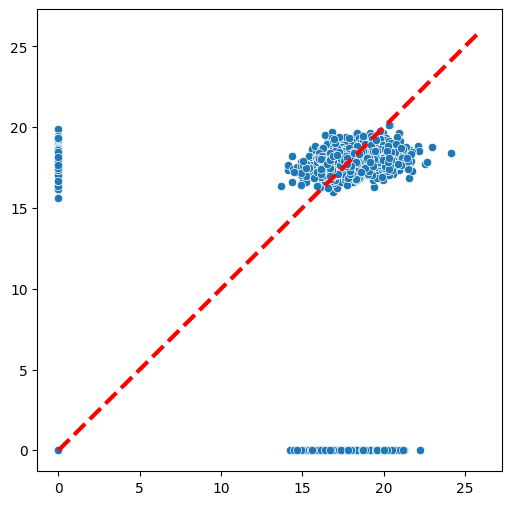

In [ ]:
Revenue_Predict_Report(y_ts_rev_result, pred_ts_rev_result)

In [ ]:
del raw_data
gc.collect()

229

#### Check point

In [ ]:
# 위에 기재된 모든 모델의 결과값 피클파일
# data_tr_rfm = pd.read_pickle("/content/drive/MyDrive/ML/ga-customer-revenue-prediction/data/co_data/data_tr_rfm_vvip.pkl")
# data_ts_rfm = pd.read_pickle("/content/drive/MyDrive/ML/ga-customer-revenue-prediction/data/co_data/data_ts_rfm_vvip.pkl")
# data_tr = pd.read_pickle("/content/drive/MyDrive/ML/ga-customer-revenue-prediction/data/co_data/data_tr_vvip.pkl")
# data_ts = pd.read_pickle("/content/drive/MyDrive/ML/ga-customer-revenue-prediction/data/co_data/data_ts_vvip.pkl")

## 결과

### TRAIN

In [ ]:
#실제 test 데이터셋에서, id, revenue 값 가져와서 vip 마킹
vvip_id = data_tr_rfm[data_tr_rfm['VIP']==2].index.tolist()
vip_id = data_tr_rfm[data_tr_rfm['VIP']==1].index.tolist()

result_tr_df = pd.concat([pd.DataFrame(data_tr.groupby('fullVisitorId')['totals_transactionRevenue'].sum()), data_tr_rfm['$']],axis=1)

result_tr_df.reset_index(inplace=True)

result_tr_df['VIP'] = 0
result_tr_df.loc[result_tr_df['fullVisitorId'].isin(vvip_id),'VIP'] = 2
result_tr_df.loc[result_tr_df['fullVisitorId'].isin(vip_id),'VIP'] = 1

result_tr_df.rename(columns={'totals_transactionRevenue':'Real_Revenue', '$':'Pred_Revenue'}, inplace=True)
result_tr_df['Real_Revenue'] = result_tr_df['Real_Revenue'] / 1000000


In [ ]:
graph_tr_df = pd.concat([pd.DataFrame(result_tr_df.groupby('VIP')['fullVisitorId'].count()), 
                      pd.DataFrame(result_tr_df.groupby('VIP')['Real_Revenue'].sum()), 
                      pd.DataFrame(result_tr_df.groupby('VIP')['Pred_Revenue'].sum())], axis=1)
graph_tr_df.rename(columns={'fullVisitorId':'count'}, inplace=True)
graph_tr_df

count  Real_Revenue   Pred_Revenue
VIP                                     
0    584369      53887.36   52973.035945
1      2345     147598.84  113556.456879
2      2412     705032.01  399829.197974

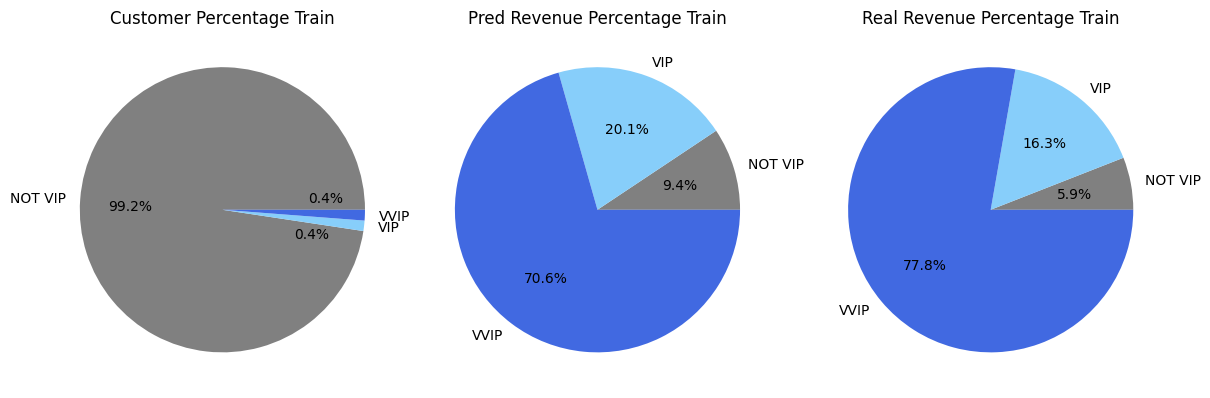

In [ ]:
# Graph
fig = plt.figure(constrained_layout = True,figsize=(12,6))
gs = GridSpec(1,3,figure=fig)

sizes = [graph_tr_df['count'][0], graph_tr_df['count'][1]*3, graph_tr_df['count'][2]*3]
ratio = graph_tr_df['count'].loc[:] / sum(graph_tr_df['count'])

plt.subplot(gs[0,0])
plt.pie(sizes, labels = ['NOT VIP','VIP','VVIP' ], autopct=None, colors=[ 'grey','lightskyblue','royalblue'], startangle=0)
plt.text(-0.8, 0, f"{ratio[0]*100:.1f}%")
plt.text(0.6, 0.05, f"{ratio[1]*100:.1f}%")
plt.text(0.5, -0.2, f"{ratio[2]*100:.1f}%")
plt.title('Customer Percentage Train')

plt.subplot(gs[0,1])
plt.pie(graph_tr_df['Pred_Revenue'], labels = ['NOT VIP','VIP','VVIP'], autopct='%.1f%%', colors=['grey','lightskyblue', 'royalblue'])
plt.title('Pred Revenue Percentage Train')

plt.subplot(gs[0,2])
plt.pie(graph_tr_df['Real_Revenue'], labels = ['NOT VIP','VIP','VVIP'], autopct='%.1f%%', colors=['grey', 'lightskyblue', 'royalblue'])
plt.title('Real Revenue Percentage Train')
plt.show()

In [ ]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Pred Revenue - Train", "Real Revenue - Train"))

fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==2,'Pred_Revenue'],name="VVIP",marker_color='RoyalBlue'),row=1, col=1)
fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==1,'Pred_Revenue'],name="VIP",marker_color='lightskyblue'),row=1, col=1)
fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==0,'Pred_Revenue'],name="NOT VIP",marker_color='grey'),row=1, col=1)

fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==2,'Real_Revenue'],name="VVIP",marker_color='RoyalBlue'),row=1, col=2)
fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==1,'Real_Revenue'],name="VIP",marker_color='lightskyblue'),row=1, col=2)
fig.add_trace(go.Box(y=result_tr_df.loc[result_tr_df['VIP']==0,'Real_Revenue'],name="NOT VIP",marker_color='grey'),row=1, col=2)

fig.update_layout(width=1200, height=700, showlegend=False)
fig.show()

### TEST

In [ ]:
#실제 test 데이터셋에서, id, revenue 값 가져와서 vip 마킹
vvip_id = data_ts_rfm[data_ts_rfm['VIP']==2].index.tolist()
vip_id = data_ts_rfm[data_ts_rfm['VIP']==1].index.tolist()

result_ts_df =pd.concat([pd.DataFrame(data_ts.groupby('fullVisitorId')['totals_transactionRevenue'].sum()), data_ts_rfm['$']],axis=1)

result_ts_df.reset_index(inplace=True)

result_ts_df['VIP'] = 0
result_ts_df.loc[result_ts_df['fullVisitorId'].isin(vvip_id),'VIP'] = 2
result_ts_df.loc[result_ts_df['fullVisitorId'].isin(vip_id),'VIP'] = 1

result_ts_df.rename(columns={'totals_transactionRevenue':'Real_Revenue', '$':'Pred_Revenue'}, inplace=True)
result_ts_df['Real_Revenue'] = result_ts_df['Real_Revenue'] / 1000000

In [ ]:
graph_ts_df = pd.concat([pd.DataFrame(result_ts_df.groupby('VIP')['fullVisitorId'].count()), 
                      pd.DataFrame(result_ts_df.groupby('VIP')['Real_Revenue'].sum()), 
                      pd.DataFrame(result_ts_df.groupby('VIP')['Pred_Revenue'].sum())], axis=1)
graph_ts_df.rename(columns={'fullVisitorId':'count'}, inplace=True)
graph_ts_df

count  Real_Revenue   Pred_Revenue
VIP                                     
0    292761     105981.56   49811.522379
1      1857     120459.48   91326.634651
2      1912     331906.90  207798.465323

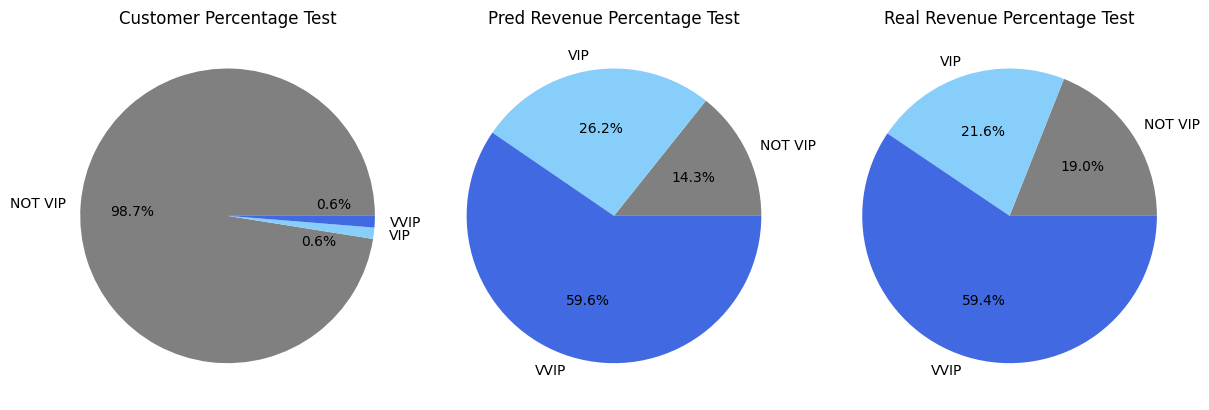

In [ ]:
# Graph
fig = plt.figure(constrained_layout = True,figsize=(12,6))
gs = GridSpec(1,3,figure=fig)

sizes = [graph_ts_df['count'][0], graph_ts_df['count'][1]*2, graph_ts_df['count'][2]*2]
ratio = graph_ts_df['count'].loc[:] / sum(graph_ts_df['count'])

plt.subplot(gs[0,0])
plt.pie(sizes, labels = ['NOT VIP','VIP','VVIP' ], autopct=None, colors=[ 'grey','lightskyblue','royalblue'], startangle=0)
plt.text(-0.8, 0, f"{ratio[0]*100:.1f}%")
plt.text(0.6, 0.05, f"{ratio[1]*100:.1f}%")
plt.text(0.5, -0.2, f"{ratio[2]*100:.1f}%")
plt.title('Customer Percentage Test')

plt.subplot(gs[0,1])
plt.pie(graph_ts_df['Pred_Revenue'], labels = ['NOT VIP','VIP','VVIP'], autopct='%.1f%%', colors=['grey','lightskyblue', 'royalblue'])
plt.title('Pred Revenue Percentage Test')

plt.subplot(gs[0,2])
plt.pie(graph_ts_df['Real_Revenue'], labels = ['NOT VIP','VIP','VVIP'], autopct='%.1f%%', colors=['grey', 'lightskyblue', 'royalblue'])
plt.title('Real Revenue Percentage Test')
plt.show()

In [ ]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Pred  Revenue - Test", "Real Revenue - Test"))

fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==2,'Pred_Revenue'],name="VVIP",marker_color='RoyalBlue'),row=1, col=1)
fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==1,'Pred_Revenue'],name="VIP",marker_color='lightskyblue'),row=1, col=1)
fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==0,'Pred_Revenue'],name="NOT VIP",marker_color='grey'),row=1, col=1)

fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==2,'Real_Revenue'],name="VVIP",marker_color='RoyalBlue'),row=1, col=2)
fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==1,'Real_Revenue'],name="VIP",marker_color='lightskyblue'),row=1, col=2)
fig.add_trace(go.Box(y=result_ts_df.loc[result_ts_df['VIP']==0,'Real_Revenue'],name="NOT VIP",marker_color='grey'),row=1, col=2)

fig.update_layout(width=1200, height=700, showlegend=False)
fig.show()

## 결론

결과적으로 Test 데이터의 고객 296,530명 중 1.2%인 약 3769명의 VIP를 탐지할 수 있었음.\
예측된 VIP 고객은 Test 데이터의 매출 중 81%를 기여하는 것으로 확인됨.\
따라서 상기 모델은 GoogleAnalytics의 로그 데이터만으로 파레토법칙에 의거한 VIP를 탐지할 수 있는 모델임을 확인함.